In [24]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [25]:
df = pd.read_csv('./brexit_enriched_age.csv.bz2', compression='bz2', sep=',')
df.head()

,Unnamed: 0,date,quotation,speaker,qids,probas,speaker_qid,date_of_birth,nationality,gender,occupation,label,age
0,0,2016-09-07,Corbyn shows his true colours. Rather than att...,Tim Farron,['Q304251'],"[['Tim Farron', '0.8865'], ['None', '0.0683'],...",Q304251,+1970-05-27T00:00:00Z,['United Kingdom'],['male'],['politician'],Tim Farron,51.0
1,1,2016-08-11,People are nervous and universities are being ...,Steve Smith,"['Q11894442', 'Q16885757', 'Q23418614', 'Q2347...","[['Steve Smith', '0.887'], ['None', '0.113']]",Q11894442,+1981-07-28T00:00:00Z,['United States of America'],['male'],['basketball player'],Steve Smith,40.0
2,2,2016-07-05,best placed to help forge a great post Brexit ...,Boris Johnson,['Q180589'],"[['Boris Johnson', '0.7713'], ['Andrea Leadsom...",Q180589,+1964-06-19T00:00:00Z,"['United States of America', 'United Kingdom']",['male'],"['journalist', 'politician', 'editor', 'writer...",Boris Johnson,57.0
3,3,2016-12-14,In the run-up to the Brexit vote earlier this ...,Janet Yellen,['Q263725'],"[['Janet Yellen', '0.6759'], ['None', '0.3241']]",Q263725,+1946-08-13T00:00:00Z,['United States of America'],['female'],"['economist', 'professor', 'banker', 'politici...",Janet Yellen,75.0
4,4,2016-07-25,"On the issue of Brexit, I speak for the people...",Martin McGuinness,['Q57689'],"[['Martin McGuinness', '0.924'], ['None', '0.0...",Q57689,+1950-05-23T00:00:00Z,['Ireland'],['male'],['politician'],Martin McGuinness,71.0


In [26]:
# derive the speakers with the maximum probability
speaker_max_prob = df['probas'].apply(lambda x: x[1:-1].split(',')[0])

# get rid of redundant symbols in strings
speaker_max_prob = speaker_max_prob.apply(lambda x: x.strip('[').replace('\'',''))

# filter out the rows where the speaker assigned is diiferent from the speaker with the maximum probability
df = df[df['speaker'] == speaker_max_prob]

# filter out the rows where the probability of the asignned speaker is lower than 0.5
prob = df['probas'].apply(lambda x: x[1:-1].split(',')).apply(lambda x: x[1].strip(']').replace('\'',''))
df = df[prob.astype(float) > 0.5]

df


,Unnamed: 0,date,quotation,speaker,qids,probas,speaker_qid,date_of_birth,nationality,gender,occupation,label,age
0,0,2016-09-07,Corbyn shows his true colours. Rather than att...,Tim Farron,['Q304251'],"[['Tim Farron', '0.8865'], ['None', '0.0683'],...",Q304251,+1970-05-27T00:00:00Z,['United Kingdom'],['male'],['politician'],Tim Farron,51.0
1,1,2016-08-11,People are nervous and universities are being ...,Steve Smith,"['Q11894442', 'Q16885757', 'Q23418614', 'Q2347...","[['Steve Smith', '0.887'], ['None', '0.113']]",Q11894442,+1981-07-28T00:00:00Z,['United States of America'],['male'],['basketball player'],Steve Smith,40.0
2,2,2016-07-05,best placed to help forge a great post Brexit ...,Boris Johnson,['Q180589'],"[['Boris Johnson', '0.7713'], ['Andrea Leadsom...",Q180589,+1964-06-19T00:00:00Z,"['United States of America', 'United Kingdom']",['male'],"['journalist', 'politician', 'editor', 'writer...",Boris Johnson,57.0
3,3,2016-12-14,In the run-up to the Brexit vote earlier this ...,Janet Yellen,['Q263725'],"[['Janet Yellen', '0.6759'], ['None', '0.3241']]",Q263725,+1946-08-13T00:00:00Z,['United States of America'],['female'],"['economist', 'professor', 'banker', 'politici...",Janet Yellen,75.0
4,4,2016-07-25,"On the issue of Brexit, I speak for the people...",Martin McGuinness,['Q57689'],"[['Martin McGuinness', '0.924'], ['None', '0.0...",Q57689,+1950-05-23T00:00:00Z,['Ireland'],['male'],['politician'],Martin McGuinness,71.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95803,95803,2020-03-02,"If the UK were to abide by EU rules, that woul...",David Frost,"['Q1174477', 'Q380865', 'Q5233878', 'Q5233879'...","[['David Frost', '0.761'], ['None', '0.2171'],...",Q1174477,+1959-09-11T00:00:00Z,['South Africa'],['male'],['golfer'],David Frost,62.0
95804,95804,2020-01-24,It is universally agreed that one thing that s...,Bishop Paul,['Q18510098'],"[['Bishop Paul', '0.8251'], ['None', '0.1749']]",Q18510098,+1953-04-06T00:00:00Z,['United States of America'],['male'],['priest'],Bishop Paul,68.0
95805,95805,2020-02-03,Sometimes I feel I am Scottish. I am very Scot...,Donald Tusk,['Q946'],"[['Donald Tusk', '0.54'], ['None', '0.3808'], ...",Q946,+1957-04-22T00:00:00Z,['Poland'],['male'],"['politician', 'historian']",Donald Tusk,64.0
95806,95806,2020-01-30,"he needs to listen to pro-Europeans, and I thi...",Ed Davey,['Q296689'],"[['Ed Davey', '0.6614'], ['None', '0.1591'], [...",Q296689,+1965-12-25T00:00:00Z,['United Kingdom'],['male'],"['politician', 'economist']",Ed Davey,56.0


In [27]:
df_speaker = df.groupby(['speaker_qid']).agg({'speaker_qid': ['count']}).sort_values(by=('speaker_qid', 'count'), ascending=False)
df_speaker = df_speaker[:20].reset_index()
df_speaker

speaker_qid      
               count
0      Q264766  3285
1      Q180589  2795
2      Q318471  1820
3      Q291169  1528
4      Q467112  1379
5         Q946   992
6     Q1728820   803
7      Q244312   660
8     Q1670096   640
9      Q438465   628
10     Q333533   606
11       Q9545   605
12     Q192533   573
13     Q574980   538
14    Q6383803   495
15   Q18388174   481
16     Q327790   457
17    Q1174175   404
18   Q18921442   394
19     Q304251   380

In [17]:
df_speaker['Speaker']=['Theresa May','Boris Johnson','Nigel Farage','Jeremy Corbyn','Nicola Sturgeon',
                       'Donald Tusk','Leo Varadkar','Vince Cable','Simon Coveney','Michel Barnier',
                       'Jeremy Hunt','Tony Blair','Mark Carney','Jacob Rees-Mogg','Keir Starmer',
                       'Philip Hammond','Jo Swinson','David Davis','Ian Blackford','Tim Farron']

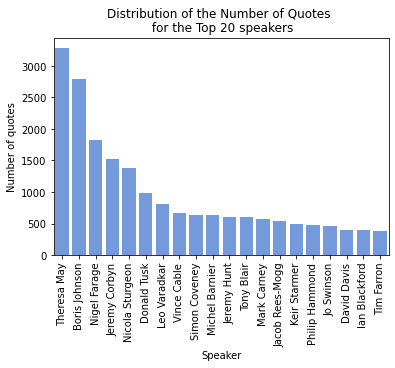

In [18]:
ax = sns.barplot(data = df_speaker, x = 'Speaker', y=('speaker_qid', 'count'),  color='cornflowerblue',alpha=1)
ax.set_xticklabels(df_speaker['Speaker'], rotation=90)
ax.set_title('Distribution of the Number of Quotes \n for the Top 20 speakers')
plt.ylabel('Number of quotes')
plt.show()